# MP4: Hidden Markov Models

In this lab, you'll train and test hidden Markov models in order to recognize spoken digits.

We're going to use python-style numbering in this MP.  So:

* The word label will be a string, $y\in\left\{"1","2","3"\right\}$.
* The waveform index will be an  integer, $0\le n<\mbox{nwaves}$.
* The state index will be $0\le i,j< \mbox{nstates}$. 
* The dimensions of the feature vector will be $0\le d<\mbox{nceps}$.  
* The number of frames will depend on the utterance index, $n$.  The frame index, $t$, will be an integer, $0\le t<\mbox{nframes[n]}$.  

We're going to assume, throughout  this MP, that 
$$\pi_i=\left\{\begin{array}{ll}1&i=0\\0&\mbox{otherwise}\end{array}\right.$$

With that assumption, the only parameters that we need to learn, for the $y^{\textrm{th}}$ word, are

$$\Lambda_y=\left\{a_{ij},\mu_{id},\Sigma_{icd}:0\le i,j<\mbox{nstates},0\le c,d<\mbox{nceps}\right\}$$.



The data for this MP are drawn from [the Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset), whose contributors are listed [here](https://github.com/Jakobovski/free-spoken-digit-dataset/graphs/contributors).  

Since that dataset is [CC-BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/), and since this MP distribution includes some data from there, this MP is also CC-BY-SA 4.0.  That means that if you revise and redistribute it, your revision should also be CC-BY-SA, or a [compatible license](https://creativecommons.org/share-your-work/licensing-considerations/compatible-licenses).

Please consider downloading the original dataset, and contributing your own voice to the dataset!

---------------------------------------------------------------------
## Part 0: Loading and playing the audio examples.

The audio are provided for you in the file `data.hdf5`, because that seemed like the easiest way to distribute them.  If you prefer, you can download the original data; we're just using all examples of waveforms "1", "2", and "3".  We're taking lucas to be the dev speaker, and yweweler to be the test speaker; all others are training speakers.

This file uses HDF5 hierarchical groups to organize its contents.  Here is how you can access the contents:

In [1]:
import os, h5py, importlib, submitted
import numpy as np
with h5py.File('data.hdf5','r') as f:
    print(f.keys())

<KeysViewHDF5 ['dev', 'test', 'train']>


In [2]:
with h5py.File('data.hdf5','r') as f:
    print(f['train'].keys())

<KeysViewHDF5 ['1', '2', '3']>


In [3]:
with h5py.File('data.hdf5','r') as f:
    for y in f['train'].keys():
        print('Training data for class Y=%s includes %d waveforms'%(y,len(f['train'][y])))

Training data for class Y=1 includes 200 waveforms
Training data for class Y=2 includes 200 waveforms
Training data for class Y=3 includes 200 waveforms


In [4]:
train_waveforms = {}
dev_waveforms = {}
test_waveforms = {}
with h5py.File('data.hdf5','r') as f:
    for y in ['1','2','3']:
        train_waveforms[y] = [ f['train'][y][i][:] for i in sorted(f['train'][y].keys()) ]
        dev_waveforms[y] = [ f['dev'][y][i][:] for i in sorted(f['dev'][y].keys()) ]
        test_waveforms[y] = [ f['test'][y][i][:] for i in sorted(f['test'][y].keys()) ]
for y in train_waveforms.keys():
    print('Training data for class Y=s%s includes %d waveforms'%(y,len(train_waveforms[y])))

Training data for class Y=s1 includes 200 waveforms
Training data for class Y=s2 includes 200 waveforms
Training data for class Y=s3 includes 200 waveforms


In [5]:
import IPython.display
print('Here is an example of the digit 1')
IPython.display.Audio(data=train_waveforms['1'][0],rate=8000)


Here is an example of the digit 1


Let's plot the first waveform of each class.

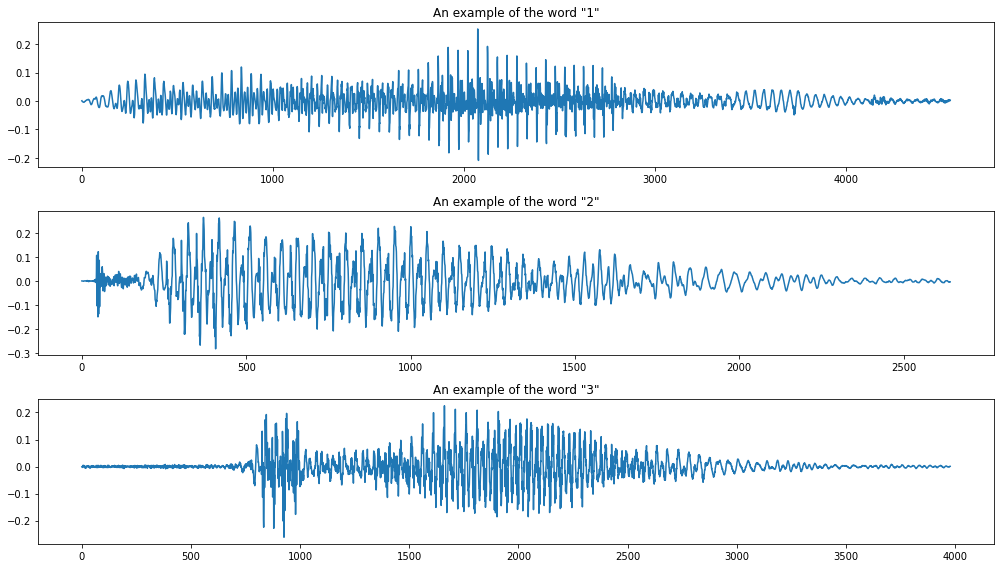

In [6]:
import matplotlib.pyplot as plt
labels = ['1','2','3']
fig, axs = plt.subplots(3,1,figsize=(14,8))
for i in range(3):
    axs[i].plot(train_waveforms[labels[i]][0])
    axs[i].set_title('An example of the word "%s"'%(labels[i]))
fig.tight_layout()

OK, now let's plot a spectrogram.  We'll use 25ms frames, overlapping by 15ms (the sampling rate is 8kHz).

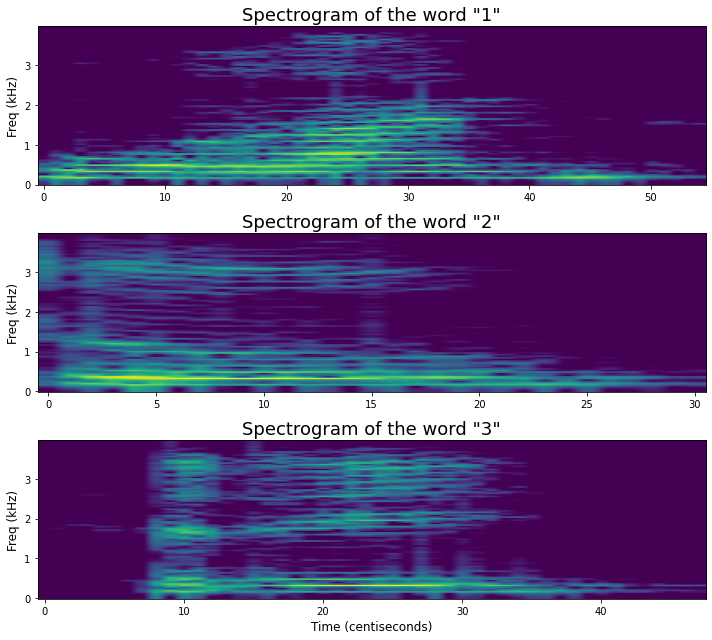

In [7]:
nframes = 1+int((10504-200)/80)
fig, axs = plt.subplots(3,1,figsize=(10,9))
for (i,y) in enumerate(('1','2','3')):
    nframes = 1 + int((len(train_waveforms[y][0])-200)/80)
    frames = np.stack([ train_waveforms[y][0][t*80:t*80+200] for t in range(nframes) ])
    spectrogram = np.log(np.maximum(0.1,np.absolute(np.fft.fft(frames)[:,0:100])))
    axs[i].imshow(spectrogram.transpose(),aspect='auto',origin='lower')
    axs[i].set_title('Spectrogram of the word "%s"'%(y),fontsize=18)
    axs[i].set_yticks([0,25,50,75])
    axs[i].set_yticklabels([0,1,2,3])
    axs[i].set_ylabel('Freq (kHz)',fontsize=12)
axs[2].set_xlabel('Time (centiseconds)',fontsize=12)
fig.tight_layout()


In these spectrograms, 
* The thin horizontal bars are **harmonics** of the fundamental frequency.  Pitch doesn't distinguish words in English (in Chinese it does).  In all three of these, you can see that the speaker has a pitch frequency of $F_0\approx 167$Hz (about six harmonics in the lowest 1kHz).
* The thick horizontal (each made up of several thin horizontal bars) are the **formant frequencies**, i.e., resonant frequencies of the all-pole filter.  These are the key features that distinguish different words in English.  In all three of these, there are four formants, though sometimes it is difficult to tell where one formant ends and the next begins.  Generally, $0<F_1<1$kHz, $1<F_2<2$kHz, $2<F_3<3$kHz, and $3<F_4<4$kHz, though sometimes one of the formants will cross outside these bands.

You can see that
* The word "1" starts with a /wa/ ($F_1$ rising from $0$ to $1$kHz, $F_2$ rising  from $1$ to $2$kHz, time $0$s to $35$cs), and ends with an /n/ (visible as a low-frequency murmur, from $35$s to $50$cs).
* The word "2" starts with a brief burst (the /t/, which is over by $1$cs), followed by an /u/ ("oo") vowel in which $F_1$ and $F_2$ are both low ($F_1\approx 400$Hz, $F_2\approx 1200$Hz), and fall during the word.
* The word "3" starts with a long nearly-silent /$\theta$/ sound ($0$ to $8$cs), followed by a clear /i/ ("ee") vowel.  The distinctive feature of the /i/ is its high, rising $F_2$ (starts at $1800$Hz, rises above $2000$Hz).

In order to keep the formant information (which tells you about the word), and discard pitch information (which tells you about the speaker), we can do something called "liftering".  Liftering a spectrogram can be done by computing its Fourier transform (called the "cepstrum"), then windowing the cepstrum, and transforming it back into a spectrum, as shown in the next block.

Text(0, 0.5, 'Frequency (frequency bins)')

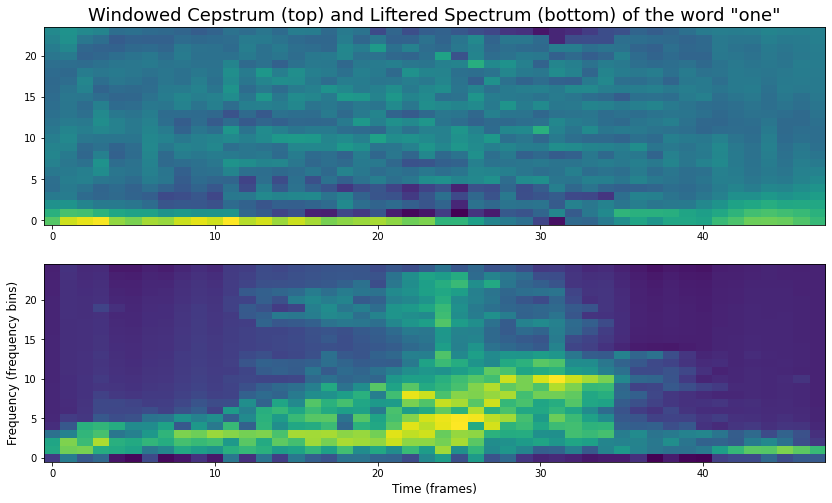

In [8]:
frames = np.array([train_waveforms['1'][0][t*80:t*80+200] for t in range(nframes)])
spectrogram = np.log(np.maximum(0.1,np.absolute(np.fft.fft(frames)[:,1:100])))
windowed_cepstrum = np.fft.fft(spectrogram)[:,0:25]
liftered_spectrum = np.real(np.fft.ifft(windowed_cepstrum))
windowed_cepstrum = np.real(windowed_cepstrum)
fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].clear()
ax[0].imshow(windowed_cepstrum[:,1:].T,aspect='auto',origin='lower')
ax[0].set_title('Windowed Cepstrum (top) and Liftered Spectrum (bottom) of the word "one"',fontsize=18)
ax[1].imshow(liftered_spectrum.transpose(),aspect='auto',origin='lower')
ax[1].set_xlabel('Time (frames)',fontsize=12)
ax[1].set_ylabel('Frequency (frequency bins)',fontsize=12)


Either the windowed cepstrum or the liftered spectrum will be reasonable representations to use for speech recognition, so they are provided for you as a utility function in `submitted.py`, as the method `compute_features`.

Text(0, 0.5, 'Frequency (frequency bins)')

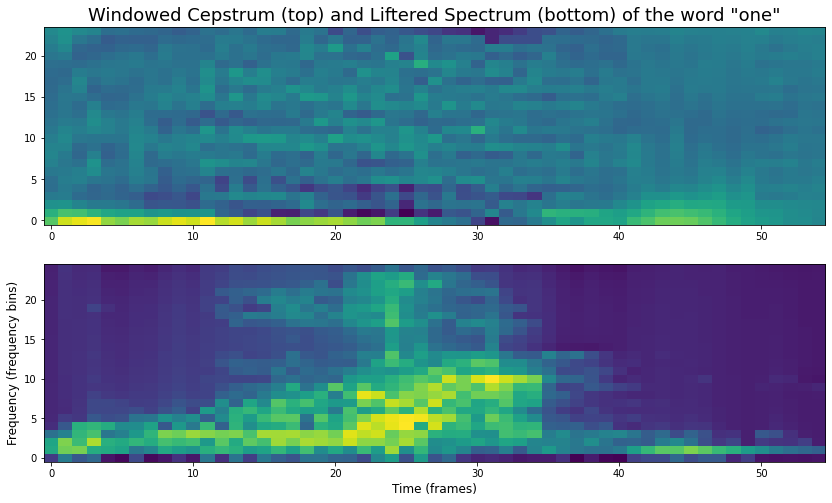

In [9]:
importlib.reload(submitted)
train_cepstra, train_spectra = submitted.compute_features(train_waveforms)
dev_cepstra, dev_spectra = submitted.compute_features(dev_waveforms)
test_cepstra, test_spectra = submitted.compute_features(test_waveforms)
fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].imshow(train_cepstra['1'][0][:,1:].T,aspect='auto',origin='lower')
ax[0].set_title('Windowed Cepstrum (top) and Liftered Spectrum (bottom) of the word "one"',fontsize=18)
ax[1].imshow(train_spectra['1'][0].transpose(),aspect='auto',origin='lower')
ax[1].set_xlabel('Time (frames)',fontsize=12)
ax[1].set_ylabel('Frequency (frequency bins)',fontsize=12)

------------------------------------------------------------
## Part 1: Initialize the HMM

Expectation-Maximization finds a local maximum of the likelihood function, not a global maximum.   The model parameters you end up with are guaranteed to be better than the parameters you start with, but that doesn't mean they're guaranteed to be **good**: the old maxim "garbage in, garbage out" applies.

In order to start with reasonable parameters, a pretty reasonable heuristic is as  follows:

1. Divide each spectrogram into `nstates` segments of uniform duration.
2. Initialize each state using the frames that have been assigned to its state.

Here is a docstring describing this process:

In [10]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.initialize_hmm)

Help on function initialize_hmm in module submitted:

initialize_hmm(X_list, nstates)
    Initialize hidden Markov models by uniformly segmenting input waveforms.
    
    Inputs:
    X_list (list of (nframes[n],nceps) arrays): 
        X_list[n][t,:] = feature vector, t'th frame of n'th waveform, for 0 <= t < nframes[n]
    nstates (scalar): 
        the number of states to initialize
    
    Returns:
    A (nstates,nstates):
        A[i,j] = p(state[t]=j | state[t-1]=i), estimates as
        (# times q[t]=j and q[t-1]=i)/(# times q[t-1]=i).
    Mu (nstates,nceps):
        Mu[i,:] = mean vector of the i'th state, estimated as
        average of the frames for which q[t]=i.
    Sigma (nstates,nceps,nceps):
        Sigma[i,:,:] = covariance matrix, i'th state, estimated as
        unbiased sample covariance of the frames for which q[t]=i.
    
    Function:
    Initialize the initial HMM by dividing each feature matrix uniformly into portions for each state:
    state i gets X_list[n][

The training data contains examples for three different words: '1', '2', and '3'.  Let's initialize each HMM using the data from the corresponding word.  

It's not clear if we want to use the cepstral features, or the spectral features.  For now, let's use the cepstra.

For example, if the function works, here's a way we can put all of the parameters into a single dict:

In [11]:
importlib.reload(submitted)
nstates = 5
Lambda = {
    '1': submitted.initialize_hmm(train_cepstra['1'], nstates),
    '2': submitted.initialize_hmm(train_cepstra['2'], nstates),
    '3': submitted.initialize_hmm(train_cepstra['3'], nstates)
}
for y in Lambda.keys():
    print('\nThe A matrix for class "%s" is \n'%(y), Lambda[y][0])



The A matrix for class "1" is 
 [[0.86052999 0.13947001 0.         0.         0.        ]
 [0.         0.86763733 0.13236267 0.         0.        ]
 [0.         0.         0.86710963 0.13289037 0.        ]
 [0.         0.         0.         0.86763733 0.13236267]
 [0.         0.         0.         0.         1.        ]]

The A matrix for class "2" is 
 [[0.84882842 0.15117158 0.         0.         0.        ]
 [0.         0.85724483 0.14275517 0.         0.        ]
 [0.         0.         0.85754986 0.14245014 0.        ]
 [0.         0.         0.         0.85724483 0.14275517]
 [0.         0.         0.         0.         1.        ]]

The A matrix for class "3" is 
 [[0.84423676 0.15576324 0.         0.         0.        ]
 [0.         0.85380117 0.14619883 0.         0.        ]
 [0.         0.         0.85347985 0.14652015 0.        ]
 [0.         0.         0.         0.85380117 0.14619883]
 [0.         0.         0.         0.         1.        ]]


It's easy to see that the $A$ matrices are OK, by scrolling  through the above.  In order to see if the $\mu$ vectors are reasonable, let's compare them to the global average cepstrum.

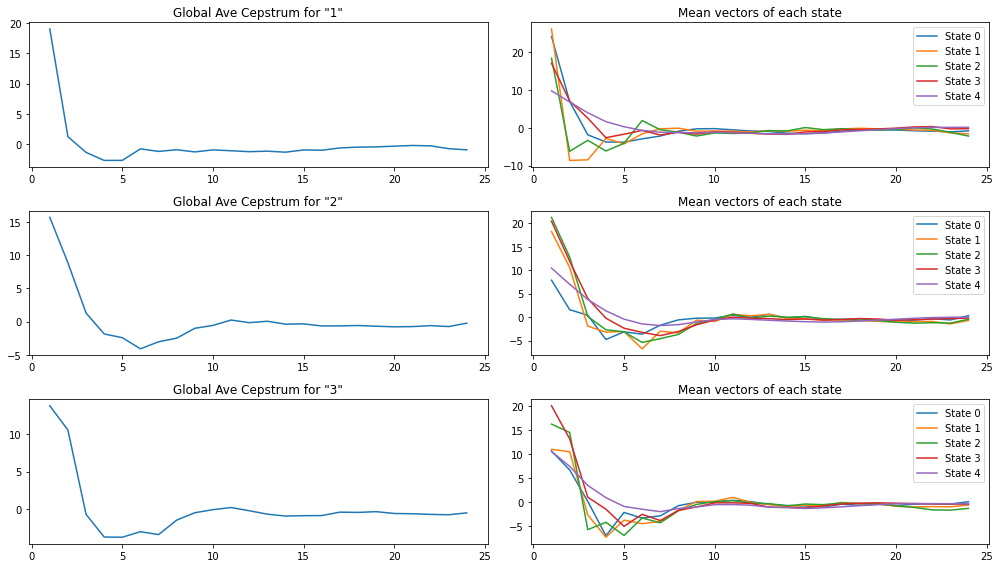

In [12]:
fig, axs = plt.subplots(3,2,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    global_mean = np.average(np.concatenate(train_cepstra[y], axis=0),axis=0)
    axs[row,0].plot(np.arange(1,len(global_mean)),global_mean[1:])
    axs[row,0].set_title('Global Ave Cepstrum for "%s"'%(y))
    meanplots = axs[row,1].plot(np.arange(1,len(global_mean)),Lambda[y][1][:,1:].T)
    axs[row,1].set_title('Mean vectors of each state')
    axs[row,1].legend(meanplots,['State 0','State 1','State 2','State 3','State 4'])
fig.tight_layout()

Similarly, let's plot the standard deviations (square roots of the main diagonal of each covariance), to see if those are reasonable.

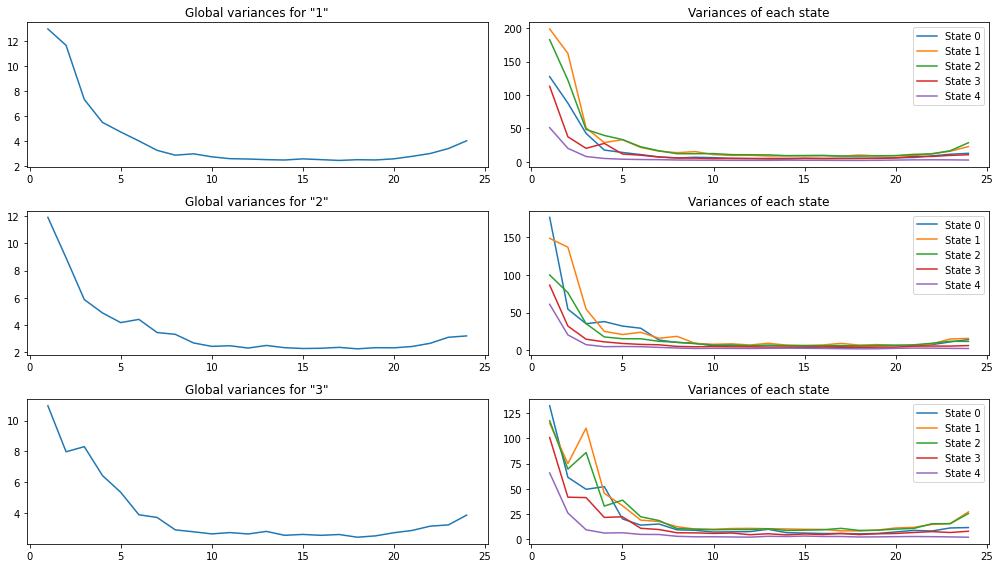

In [13]:
fig, axs = plt.subplots(3,2,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    global_std = np.std(np.concatenate(train_cepstra[y], axis=0),axis=0)
    axs[row,0].plot(np.arange(1,len(global_std)),global_std[1:])
    axs[row,0].set_title('Global variances for "%s"'%(y))
    for i in range(nstates):
        state_std = np.diag(Lambda[y][2][i,1:,1:])
        axs[row,1].plot(np.arange(1,len(global_std)),state_std,label='State %d'%(i))
    axs[row,1].set_title('Variances of each state')
    axs[row,1].legend()
fig.tight_layout()

Finally, let's check the eigenvalues of each covariance matrix, to make sure they're also reasonable.

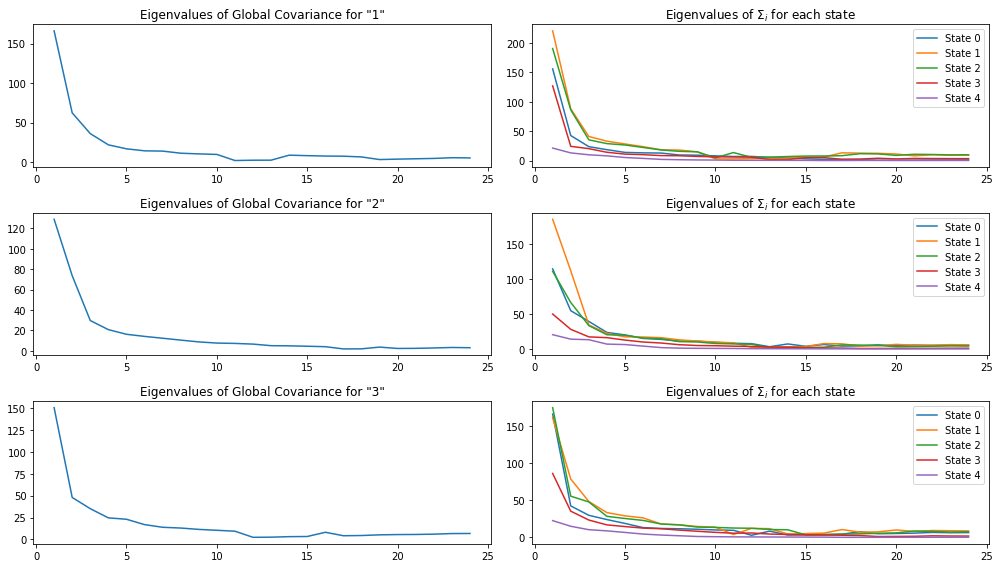

In [14]:
fig, axs = plt.subplots(3,2,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    global_eigs, _ = np.linalg.eig(np.cov(np.concatenate(train_cepstra[y], axis=0),rowvar=False))
    axs[row,0].plot(np.arange(1,len(global_eigs)),global_eigs[1:])
    axs[row,0].set_title('Eigenvalues of Global Covariance for "%s"'%(y))
    for i in range(nstates):
        state_eigs, _ = np.linalg.eig(Lambda[y][2][i,:,:])
        axs[row,1].plot(np.arange(1,len(state_eigs)),state_eigs[1:],label='State %d'%(i))
    axs[row,1].set_title('Eigenvalues of $\Sigma_i$ for each state')
    axs[row,1].legend()
fig.tight_layout()

The following code blocks are inserted to help you debug.  These compare your results, in each of the above areas, to the results saved in `solutions.hdf5`.  If there are any results that are not zero, you should try to figure out why.

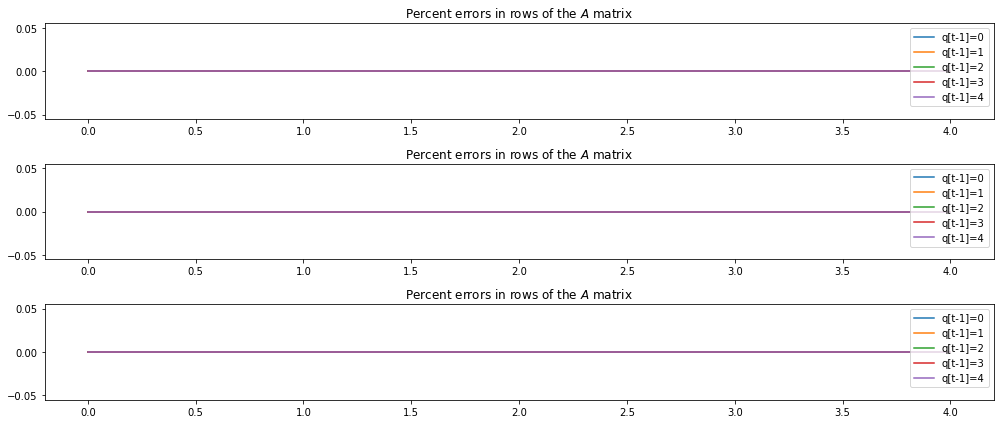

In [15]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        A = Lambda[y][0]
        for i in range(nstates):
            err = (A[i,:]-h5['Lambda'][y]['0'][i,:])/np.average(np.abs(h5['Lambda'][y]['0'][i,:]))
            axs[k].plot(100*err,label='q[t-1]=%d'%(i))
        axs[k].set_title('Percent errors in rows of the $A$ matrix')
        axs[k].legend()
    fig.tight_layout()

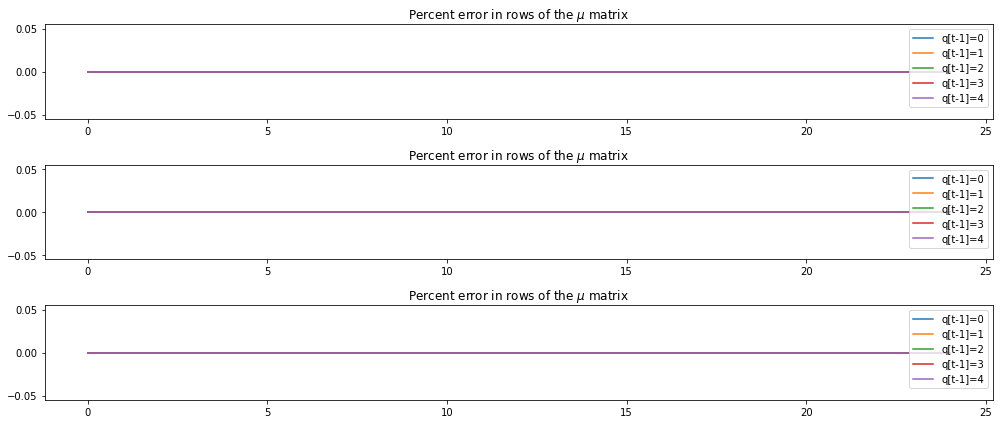

In [16]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        Mu = Lambda[y][1]
        for i in range(nstates):
            err = (Mu[i,:]-h5['Lambda'][y]['1'][i,:])/np.average(np.abs(h5['Lambda'][y]['1'][i,:]))
            axs[k].plot(100*err,label='q[t-1]=%d'%(i))
        axs[k].set_title('Percent error in rows of the $\mu$ matrix')
        axs[k].legend()
    fig.tight_layout()

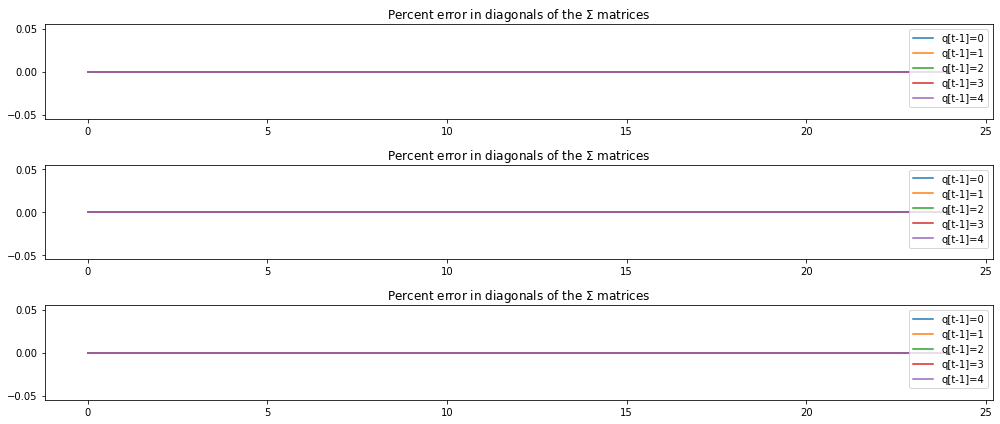

In [17]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        Sigma = Lambda[y][2]
        ref = h5['Lambda'][y]['2']
        for i in range(nstates):
            err = np.diag(Sigma[i,:,:]-ref[i,:,:])/np.average(np.abs(np.diag(ref[i,:,:])))
            axs[k].plot(100*err,label='q[t-1]=%d'%(i))
        axs[k].set_title('Percent error in diagonals of the $\Sigma$ matrices')
        axs[k].legend()
    fig.tight_layout()

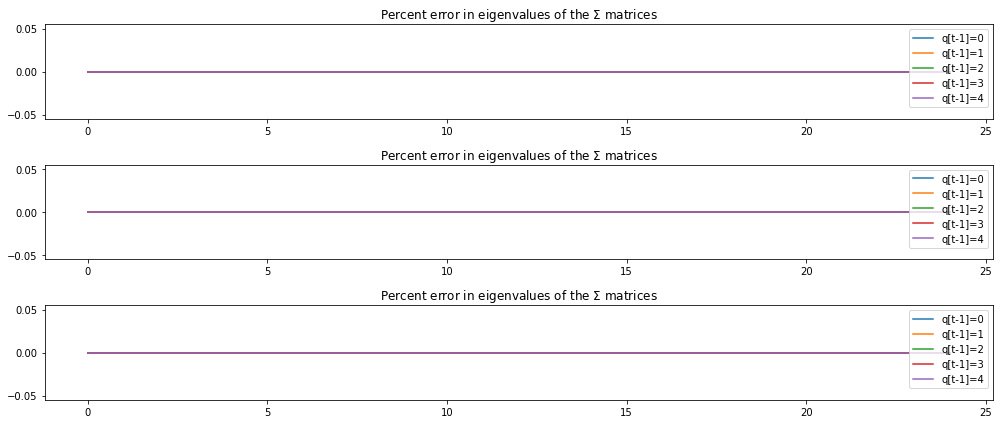

In [18]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        for i in range(nstates):
            eigs_mine, _ = np.linalg.eig(Lambda[y][2][i,:,:])
            eigs_solution, _ = np.linalg.eig(h5['Lambda'][y]['2'][i,:,:])
            err = (eigs_mine-eigs_solution)/np.average(np.abs(eigs_solution))
            axs[k].plot(100*err,label='q[t-1]=%d'%(i))
        axs[k].set_title('Percent error in eigenvalues of the $\Sigma$ matrices')
        axs[k].legend()
    fig.tight_layout()


-------------------------------------
## Part 2: Calculate the observation pdf

The observation pdf is a multivariate normal distribution.  For numerical stability, we floor it by $10^{-100}$, just to make sure that none of the values get smaller than that.

$$b_i(\vec{x}_t) = \max\left(\frac{1}{(2\pi)^{D/2}|\Sigma_i|^{1/2}}e^{-\frac{1}{2}(\vec{x}_t-\vec\mu_i)^T\Sigma_i^{-1}(\vec{x}_t-\vec\mu_i)}, 10^{-100}\right)$$

You can program this yourself, but it's also OK to use `scipy.stats.multivariate_normal`.  The autograder will have scipy available this time.

Notice that what we're doing is replacing each $X$ matrix (these are size-`(nframes,nceps)` matrices, with one cepstral vector per frame) by a $B$ matrix (these are size-`(nframes,nstates)` matrices, in which `B[t,i]` contains $b_i(\vec{x}_t)$ for the $n^\textrm{th}$ utterance). 

In [19]:
importlib.reload(submitted)
help(submitted.observation_pdf)

Help on function observation_pdf in module submitted:

observation_pdf(X, Mu, Sigma)
    Calculate the log observation PDFs for every frame, for every state.
    
    Inputs:
    X (nframes,nceps):
        X[t,:] = feature vector, t'th frame of n'th waveform, for 0 <= t < nframes[n]
    Mu (nstates,nceps):
        Mu[i,:] = mean vector of the i'th state
    Sigma (nstates,nceps,nceps):
        Sigma[i,:,:] = covariance matrix, i'th state
    
    Returns:
    B (nframes,nstates):
        B[t,i] = max(p(X[t,:] | Mu[i,:], Sigma[i,:,:]), 1e-100)
    
    Function:
    The observation pdf, here, should be a multivariate Gaussian.
    You can use scipy.stats.multivariate_normal.pdf.



In [20]:
importlib.reload(submitted)
B_dict = { y:[] for y in ['1','2','3'] }
for y in ['1','2','3']:
    for X in train_cepstra[y]:
        B = submitted.observation_pdf(X, Lambda[y][1], Lambda[y][2])
        B_dict[y].append(B)
    print('B_dict[%s] is a list of %d B matrices'%(y,len(B_dict[y])))

B_dict[1] is a list of 200 B matrices
B_dict[2] is a list of 200 B matrices
B_dict[3] is a list of 200 B matrices


The $B$ matrix has a huge, huge dynamic range.  If you try to visualize the raw probability, most of what you see will look like zero.  Instead, it is more useful to visualize the log probability, as shown here:

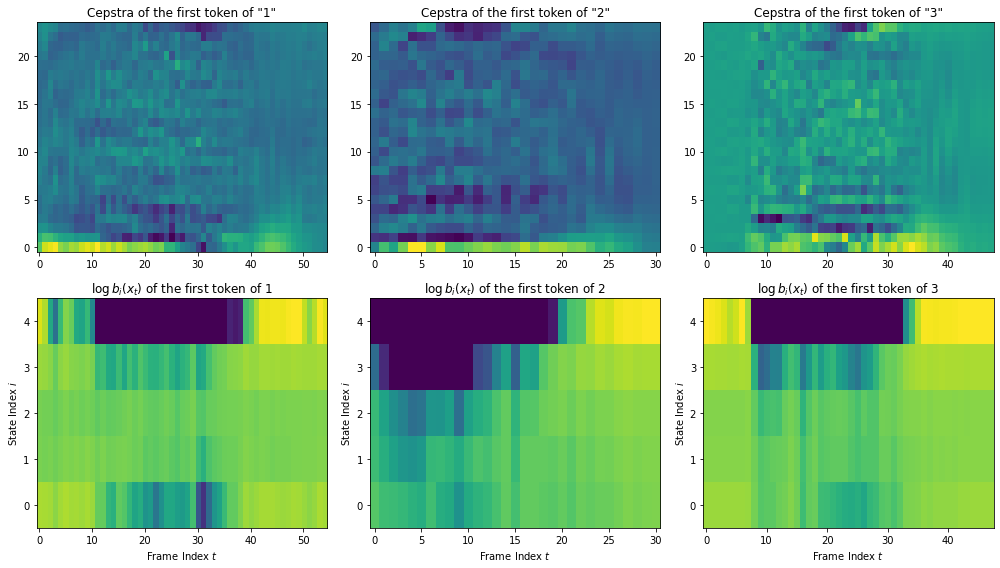

In [21]:
fig, axs = plt.subplots(2,3,figsize=(14,8))
Y=['1','2','3']
for col in range(3):
    y = Y[col]
    normalized_B = np.log(B_dict[y][0])
    axs[0,col].imshow(train_cepstra[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Cepstra of the first token of "%s"'%(y))
    axs[1,col].imshow(normalized_B.T,aspect='auto',origin='lower')
    axs[1,col].set_title('$\log b_i(x_t)$ of the first token of %s'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    axs[1,col].set_xlabel('Frame Index $t$')
fig.tight_layout()


Here's some code to help you debug, by showing the percentage difference between your solutions and the solutions in `solutions.hdf5` in the first example of the word "1".

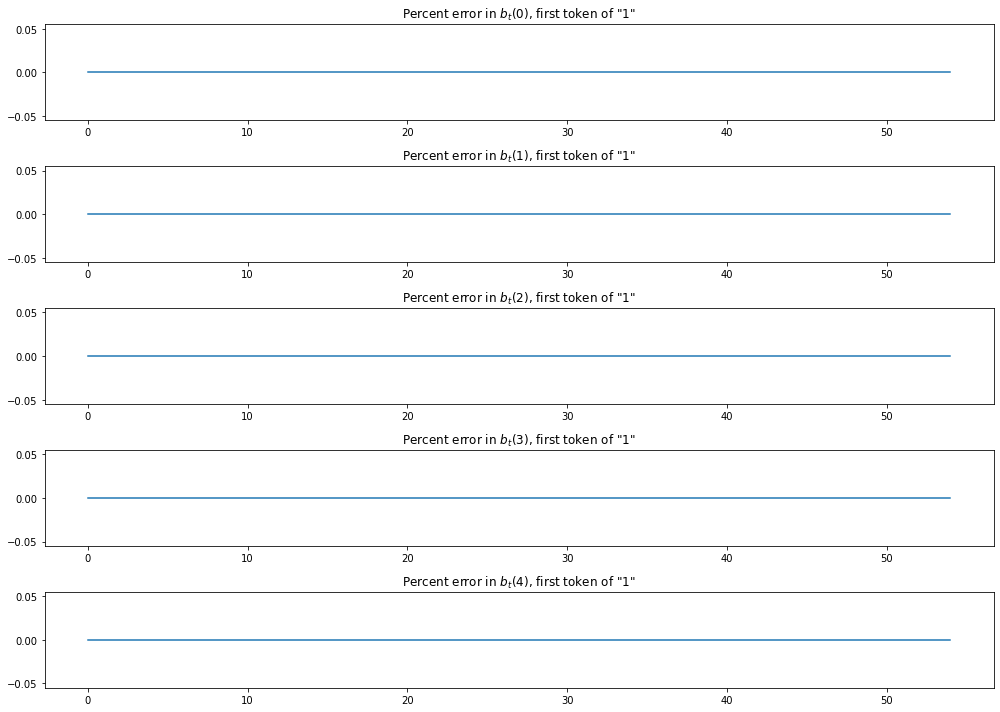

In [22]:
fig, axs = plt.subplots(5,1,figsize=(14,10))
with h5py.File('solutions.hdf5','r') as h5:
    for i in range(5):
        ref = h5['B_dict']['1']['0']
        axs[i].plot(100*(B_dict['1'][0][:,i]-ref[:,i])/np.average(np.abs(ref[:,i])))
        axs[i].set_title('Percent error in $b_t(%d)$, first token of "1"'%(i))
fig.tight_layout()

-------------------------------------------------------------
## Part 3: Scaled Forward Algorithm

The first step in training the HMM is the scaled forward algorithm.  It computes two variables, $\hat\alpha_t(i)$ and $g_t$.  The definitions of these variables are:

$$\hat\alpha_t(i) = p(q_t=i|\vec{x}_1,\ldots,\vec{x}_t,\Lambda)$$
$$g_t = p(\vec{x}_t|\vec{x}_1,\ldots,\vec{x}_{t-1},\Lambda)$$

These can be computed using the scaled forward algorithm:

1. **Initialize** (note, we assume $\pi_0=1$, and $\pi_i=0\forall i\ne 0$):
$$\tilde\alpha_1(i)=\pi_i b_i(\vec{x}_1)$$
$$g_1 = \sum_i\tilde\alpha_1(i)$$
$$\hat\alpha_1(i) = \frac{\tilde\alpha_1(i)}{g_1}$$

2. **Iterate**
$$\tilde\alpha_t(j)=\sum_{i=0}^{N-1}\hat\alpha_{t-1}(i)a_{ij}b_j(\vec{x}_t)$$
$$g_t = \sum_j\tilde\alpha_t(j)$$
$$\hat\alpha_t(j) = \frac{\tilde\alpha_t(j)}{g_t}$$

3. **Terminate** (note: this part will be calculated later, in the function `submitted.recognize`)
$$p(X|\Lambda) = \prod_{t=1}^T g_t$$


In [23]:
importlib.reload(submitted)
help(submitted.scaled_forward)

Help on function scaled_forward in module submitted:

scaled_forward(A, B)
    Perform the scaled forward algorithm.
    
    Inputs:
    A (nstates,nstates):
        A[i,j] = p(state[t]=j | state[t-1]=i)
    B (nframes,nstates):
        B[t,i] = p(X[t,:] | Mu[i,:], Sigma[i,:,:])
    
    Returns:
    Alpha_Hat (nframes,nstates):
        Alpha_Hat[t,i] = p(q[t]=i | X[:t,:], A, Mu, Sigma)
        (that's its definition.  That is not the way you should compute it).
    G (nframes):
        G[t] = p(X[t,:] | X[:t,:], A, Mu, Sigma)
        (that's its definition.  That is not the way you should compute it).
    
    Function:
    Assume that the HMM starts in state q_1=0, with probability 1.
    With that assumption, implement the scaled forward algorithm.



In [24]:
importlib.reload(submitted)
Alpha_dict = { y:[] for y in ['1','2','3'] }
G_dict = { y:[] for y in ['1','2','3'] }
for y in ['1','2','3']:
    for B in B_dict[y]:
        Alpha_Hat, G = submitted.scaled_forward(Lambda[y][0], B)
        Alpha_dict[y].append(Alpha_Hat)
        G_dict[y].append(G)
    print('Alpha_dict[%s] is a list of %d Alpha_Hat matrices'%(y,len(Alpha_dict[y])))


Alpha_dict[1] is a list of 200 Alpha_Hat matrices
Alpha_dict[2] is a list of 200 Alpha_Hat matrices
Alpha_dict[3] is a list of 200 Alpha_Hat matrices


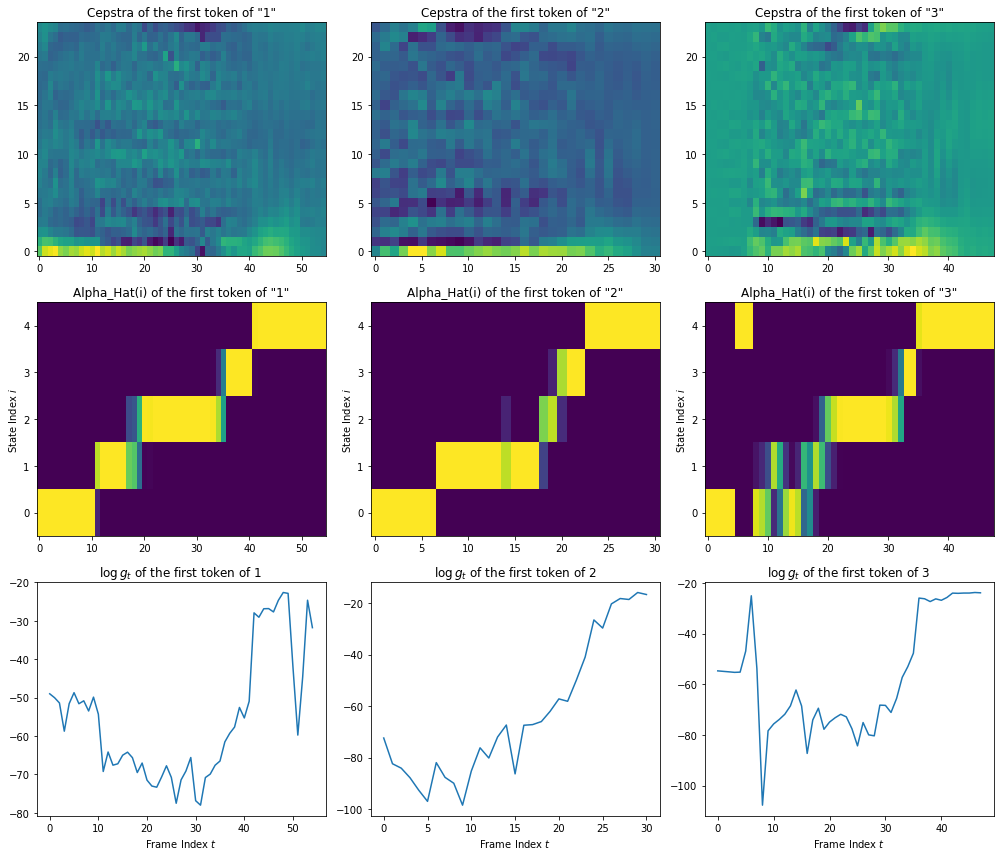

In [25]:
fig, axs = plt.subplots(3,3,figsize=(14,12))
Y=['1','2','3']
for col in range(3):
    y = Y[col]
    axs[0,col].imshow(train_cepstra[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Cepstra of the first token of "%s"'%(y))
    axs[1,col].imshow(Alpha_dict[y][0].T,aspect='auto',origin='lower')
    axs[1,col].set_title('Alpha_Hat(i) of the first token of "%s"'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    axs[2,col].plot(np.log(G_dict[y][0]))
    axs[2,col].set_title('$\log g_t$ of the first token of %s'%(y))
    axs[2,col].set_xlabel('Frame Index $t$')
fig.tight_layout()



The vector $D$ lists the eigenvalues of the gram matrix, which are also the eigenvalues of the sum-of-squares matrix (the scaled covariance).  If you add them, you get the total variance of all samples in the dataset.

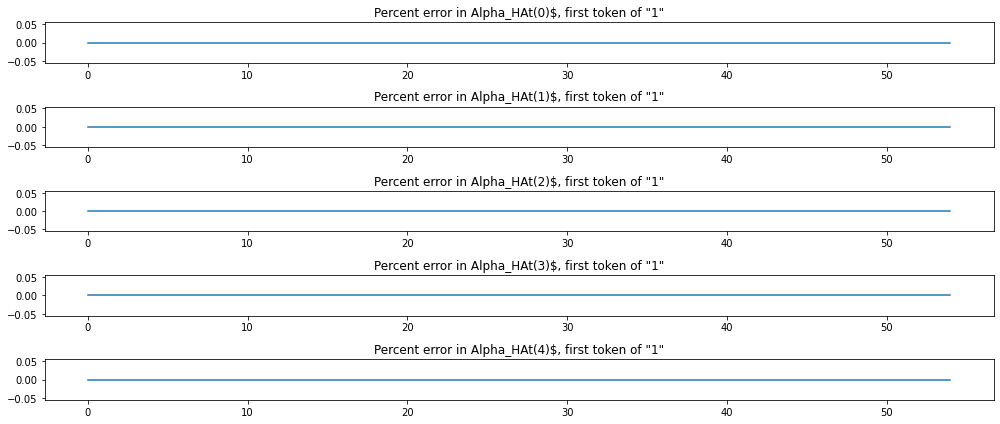

In [26]:
fig, axs = plt.subplots(5,1,figsize=(14,6))
with h5py.File('solutions.hdf5','r') as h5:
    ref = h5['Alpha_dict']['1']['0'][:]
    Alpha_Hat = Alpha_dict['1'][0]
    for i in range(5):
        err = (Alpha_Hat[:,i]-ref[:,i])/np.average(np.abs(ref[:,i]))
        axs[i].plot(100*err)
        axs[i].set_title('Percent error in Alpha_HAt(%d)$, first token of "1"'%(i))
fig.tight_layout()

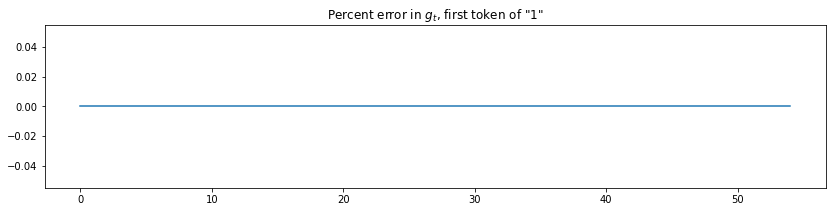

In [27]:
fig, axs = plt.subplots(1,1,figsize=(14,3))
with h5py.File('solutions.hdf5','r') as h5:
    ref = h5['G_dict']['1']['0']
    axs.plot(100*(G_dict['1'][0][:]-ref[:])/np.average(np.abs(ref[:])))
    axs.set_title('Percent error in $g_t$, first token of "1"')

-----------------------------------------------------------
## Part 4: Scaled backward

Like the scaled forward algorithm, the **scaling** in the scaled backward algorithm is supposed to compensate for numerical underflow and numerical overflow errors.  Unfortunately, with Gaussians, the standard scaled backward algorithm (from the Rabiner article)  doesn't compensate well enough.  Instead, let's use the following definition:

$$\hat\beta_t(i) = \frac{p(x_{t+1},\ldots,x_T|q_t=i,\Lambda)}{\max_j p(x_{t+1},\ldots,x_T|q_t=i,\Lambda)}$$

In order to avoid any numerical overflow or underflow, the normalization has to be done in every single time step, like this:

1. **Initialize**:
$$\hat\beta_T(i)=1$$

2. **Iterate**
$$\tilde\beta_t(i)=\sum_{j=0}^{N-1}a_{ij}b_j(\vec{x}_{t+1})\hat\beta_{t+1}(j)$$
$$c_t=\max_i\tilde\beta_t(i)$$
$$\hat\beta_t(i) = \frac{\tilde\beta_t(i)}{c_t}$$




In [28]:
importlib.reload(submitted)
help(submitted.scaled_backward)

Help on function scaled_backward in module submitted:

scaled_backward(A, B)
    Perform the scaled backward algorithm.
    
    Inputs:
    A (nstates,nstates):
        A[y][i,j] = p(state[t]=j | state[t-1]=i)
    B (nframes,nstates):
        B[t,i] = p(X[t,:] | Mu[i,:], Sigma[i,:,:])
    
    Returns:
    Beta_Hat (nframes,nstates):
        Beta_Hat[t,i] = p(X[t+1:,:]| q[t]=i, A, Mu, Sigma) / max_j p(X[t+1:,:]| q[t]=j, A, Mu, Sigma)
        (that's its definition.  That is not the way you should compute it).



In [29]:
importlib.reload(submitted)
Beta_dict = { y:[] for y in ['1','2','3'] }
for y in ['1','2','3']:
    for B in B_dict[y]:
        Beta_Hat = submitted.scaled_backward(Lambda[y][0], B)
        Beta_dict[y].append(Beta_Hat)
    print('Beta_dict[%s] is a list of %d Beta_Hat matrices'%(y,len(Beta_dict[y])))


Beta_dict[1] is a list of 200 Beta_Hat matrices
Beta_dict[2] is a list of 200 Beta_Hat matrices
Beta_dict[3] is a list of 200 Beta_Hat matrices


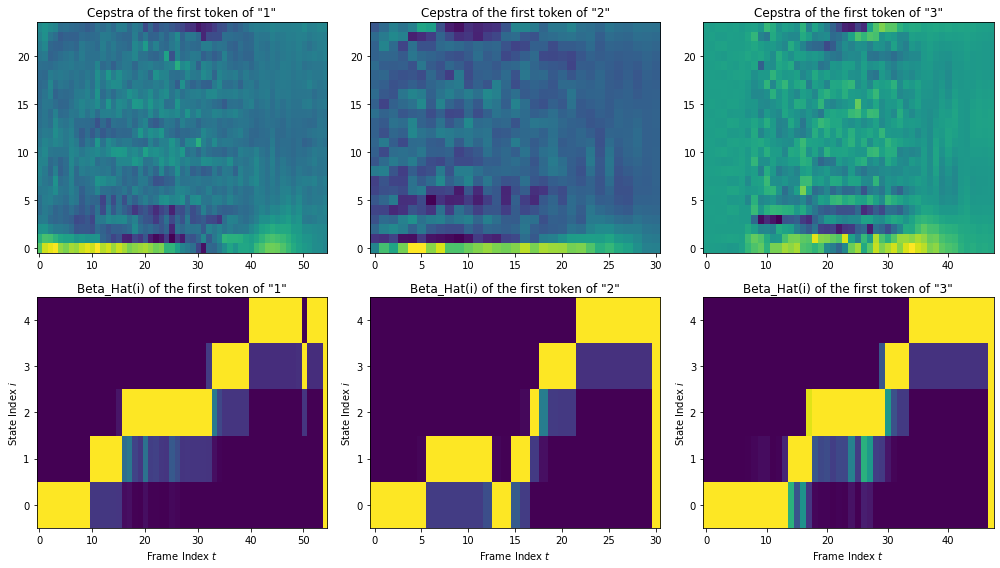

In [30]:
fig, axs = plt.subplots(2,3,figsize=(14,8))
Y=['1','2','3']
for col in range(3):
    y = Y[col]
    axs[0,col].imshow(train_cepstra[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Cepstra of the first token of "%s"'%(y))
    axs[1,col].imshow(Beta_dict[y][0].T,aspect='auto',origin='lower')
    axs[1,col].set_title('Beta_Hat(i) of the first token of "%s"'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    axs[1,col].set_xlabel('Frame Index $t$')
fig.tight_layout()



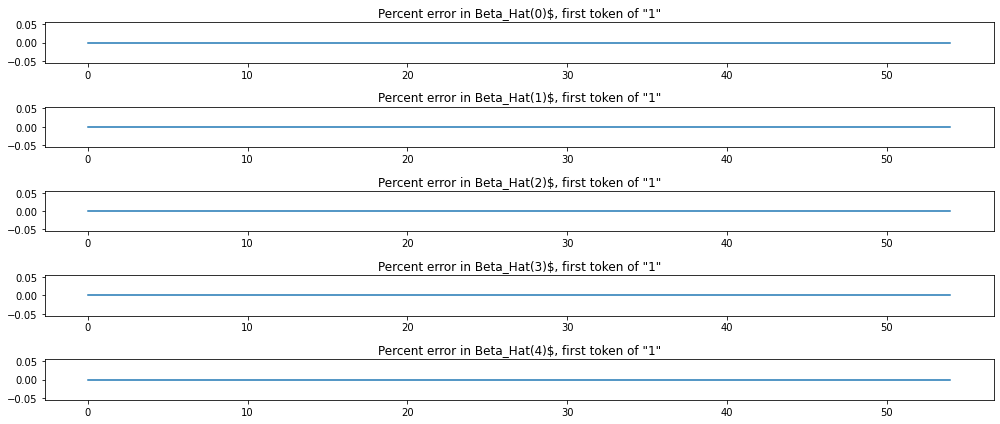

In [31]:
fig, axs = plt.subplots(5,1,figsize=(14,6))
with h5py.File('solutions.hdf5','r') as h5:
    for i in range(5):
        ref = h5['Beta_dict']['1']['0']
        axs[i].plot(100*(Beta_dict['1'][0][:,i]-ref[:,i])/np.average(np.abs(ref[:,i])))
        axs[i].set_title('Percent error in Beta_Hat(%d)$, first token of "1"'%(i))
fig.tight_layout()

-----------------------------------------------------------------------------
## Part 5: Find the state and segment posterior probabilities

The state posterior probability is $\gamma_t(i)=p(q_t=i|X,\Lambda)$.  The segment posterior probability is $\xi_t(i,j)=p(q_t=i,q_{t+1}=j|X,\Lambda)$.

In [32]:
importlib.reload(submitted)
help(submitted.posteriors)

Help on function posteriors in module submitted:

posteriors(A, B, Alpha_Hat, Beta_Hat)
    Calculate the state and segment posteriors for an HMM.
    
    Inputs:
    A (nstates,nstates):
        A[y][i,j] = p(state[t]=j | state[t-1]=i)
    B (nframes,nstates):
        B[t,i] = p(X[t,:] | Mu[i,:], Sigma[i,:,:])
    Alpha_Hat (nframes,nstates):
        Alpha_Hat[t,i] = p(q=i | X[:t,:], A, Mu, Sigma)
    Beta_Hat (nframes,nstates):
        Beta_Hat[t,i] = p(X[t+1:,:]| q[t]=i, A, Mu, Sigma) / prod(G[t+1:])
    
    Returns:
    Gamma (nframes,nstates):
        Gamma[t,i] = p(q[t]=i | X, A, Mu, Sigma)
                   = Alpha_Hat[t,i]*Beta_Hat[t,i] / sum_i numerator
    Xi (nframes-1,nstates,nstates):
        Xi[t,i,j] = p(q[t]=i, q[t+1]=j | X, A, Mu, Sigma)
                  = Alpha_Hat[t,i]*A{i,j]*B[t+1,j]*Beta_Hat[t+1,j] / sum_{i,j} numerator
    
    
    Implementation Warning:
    The denominators, in either Gamma or Xi, might sometimes become 0 because of roundoff error.
    YOU 

In [33]:
importlib.reload(submitted)
Gamma_dict = { y:[] for y in ['1','2','3'] }
Xi_dict = { y:[] for y in ['1','2','3'] }
for y in ['1','2','3']:
    for n, (B, Alpha_Hat, Beta_Hat) in enumerate(zip(B_dict[y], Alpha_dict[y], Beta_dict[y])):
        Gamma, Xi = submitted.posteriors(Lambda[y][0], B, Alpha_Hat, Beta_Hat)
        Gamma_dict[y].append(Gamma)
        Xi_dict[y].append(Xi)
    print('Gamma_dict[%s] is a list of %d Gamma matrices'%(y,len(Gamma_dict[y])))


Gamma_dict[1] is a list of 200 Gamma matrices
Gamma_dict[2] is a list of 200 Gamma matrices
Gamma_dict[3] is a list of 200 Gamma matrices


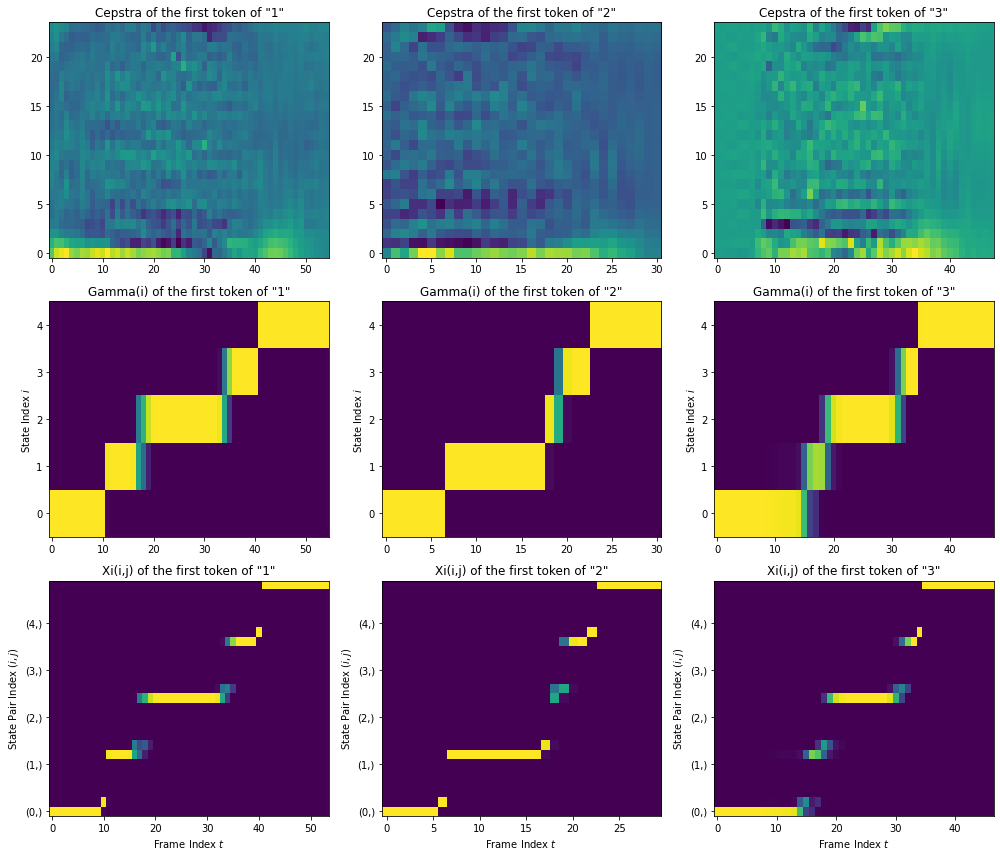

In [34]:
fig, axs = plt.subplots(3,3,figsize=(14,12))
Y=['1','2','3']
for col in range(3):
    y = Y[col]
    axs[0,col].imshow(train_cepstra[y][0][:,1:].T,aspect='auto',origin='lower')
    axs[0,col].set_title('Cepstra of the first token of "%s"'%(y))
    axs[1,col].imshow(Gamma_dict[y][0].T,aspect='auto',origin='lower')
    axs[1,col].set_title('Gamma(i) of the first token of "%s"'%(y))
    axs[1,col].set_ylabel('State Index $i$')
    (nframes,states)=Gamma_dict[y][0].shape
    axs[2,col].imshow(Xi_dict[y][0].reshape((nframes-1,nstates*nstates)).T,aspect='auto',origin='lower')
    axs[2,col].set_title('Xi(i,j) of the first token of "%s"'%(y))
    axs[2,col].set_ylabel('State Pair Index $(i,j)$')
    axs[2,col].set_yticks([0,5,10,15,20])
    axs[2,col].set_yticklabels(['(0,)','(1,)','(2,)','(3,)','(4,)'])
    axs[2,col].set_xlabel('Frame Index $t$')
fig.tight_layout()


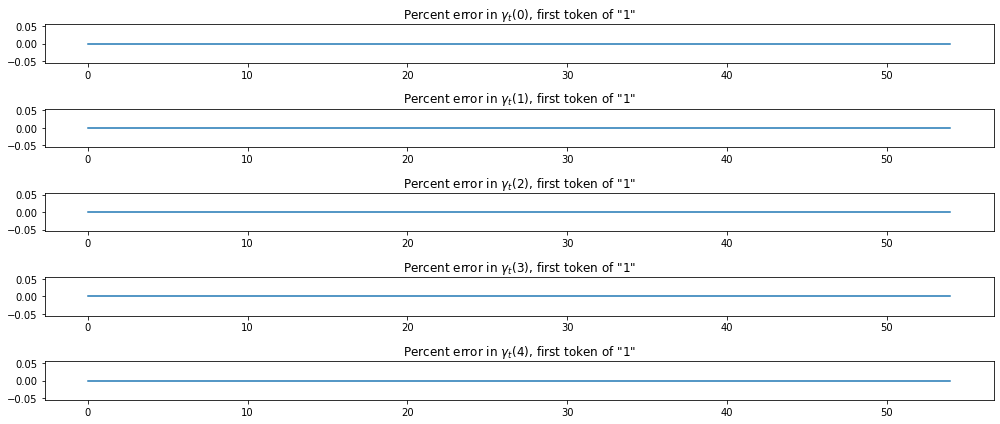

In [35]:
fig, axs = plt.subplots(5,1,figsize=(14,6))
with h5py.File('solutions.hdf5','r') as h5:
    for i in range(5):
        ref = h5['Gamma_dict']['1']['0']
        axs[i].plot(100*(Gamma_dict['1'][0][:,i]-ref[:,i])/np.average(np.abs(ref[:,i])))
        axs[i].set_title('Percent error in $\gamma_t(%d)$, first token of "1"'%(i))
fig.tight_layout()

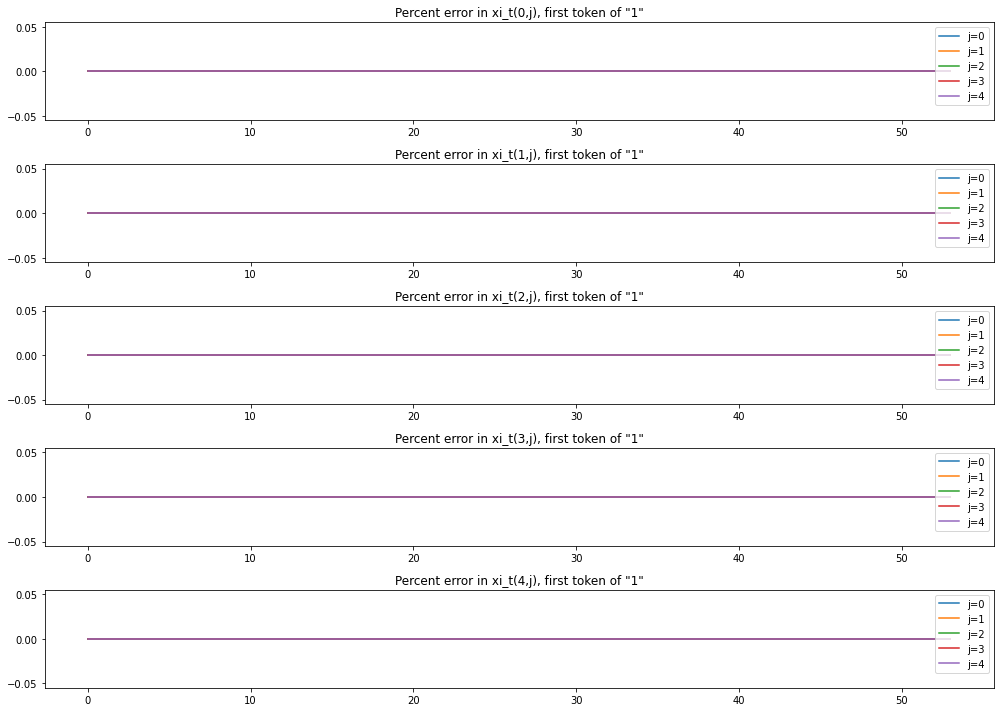

In [36]:
fig, axs = plt.subplots(5,1,figsize=(14,10))
with h5py.File('solutions.hdf5','r') as h5:
    for i in range(5):
        ref = h5['Xi_dict']['1']['0']
        for j in range(5):
            err=(Xi_dict['1'][0][:,i,j]-ref[:,i,j])/np.average(np.abs(ref[:,i,:]))
            axs[i].plot(100*err,label='j=%d'%(j))
        axs[i].set_title('Percent error in xi_t(%d,j), first token of "1"'%(i))
        axs[i].legend()
fig.tight_layout()

-------------------------------------------------------------------------------------
## Part 6: E-Step

For the E-step in an HMM, we want to find the expected values of the numerators and denominators that will be used in the M-step.  These are things like:

$$A_{num}[i,j] = \sum_t \xi_t(i,j)$$
$$A_{den}[i,j] = \sum_j\sum_t\xi_t(i,j)$$
$$\mu_{num}[i,:] = \sum_t\gamma_t(i)\vec{x}_t$$
$$\mu_{den}[i]=\sum_t\gamma_t(i)$$
$$\Sigma_{num}[i,:,:]=\sum_t\gamma_t(i)(\vec{x}_t-\vec\mu_i)(\vec{x}_t-\vec\mu_i)^T$$
$$\Sigma_{den}[i]=\sum_t\gamma_t(i)$$

Notice a couple of weird things here:
* Even though this function doesn't return the newest value of $\vec\mu_i$, you still need to compute it internally, so that you can find $\Sigma_{num}$.
* This function sums over $t$, but we really want to sum over both $t$ and $n$ -- we want to sum over all waveforms that correspond to a particular word!  In order to make that happen, the $X$, $\Gamma$, and $\Xi$ matrices that we pass to this function will be the vertical concatanetion of all of the matrices from all of the corresponding waveforms.

In [37]:
importlib.reload(submitted)
help(submitted.E_step)

Help on function E_step in module submitted:

E_step(X, Gamma, Xi)
    Calculate the expectations for an HMM.
    
    Inputs:
    X (nframes,nceps):
        X[t,:] = feature vector, t'th frame of n'th waveform
    Gamma (nframes,nstates):
        Gamma[t,i] = p(q[t]=i | X, A, Mu, Sigma)
    Xi (nsegments,nstates,nstates):
        Xi_list[t,i,j] = p(q[t]=i, q[t+1]=j | X, A, Mu, Sigma)
    
    Returns:
    A_num (nstates,nstates): 
        A_num[i,j] = E[# times q[t]=i,q[t+1]=j]
    A_den (nstates): 
        A_den[i] = E[# times q[t]=i]
    Mu_num (nstates,nceps): 
        Mu_num[i,:] = E[X[t,:]|q[t]=i] * E[# times q[t]=i]
    Mu_den (nstates): 
        Mu_den[i] = E[# times q[t]=i]
    Sigma_num (nstates,nceps,nceps): 
        Sigma_num[i,:,:] = E[(X[t,:]-Mu[i,:])@(X[t,:]-Mu[i,:]).T|q[t]=i] * E[# times q[t]=i]
    Sigma_den (nstates): 
        Sigma_den[i] = E[# times q[t]=i]



In [38]:
importlib.reload(submitted)
expectations = {}
for y in ['1','2','3']:
    expectations[y] = submitted.E_step(np.concatenate(train_cepstra[y]), np.concatenate(Gamma_dict[y]), np.concatenate(Xi_dict[y]))
    print('expectations[%s] is a tuple with %d elements'%(y,len(expectations[y])))

expectations[1] is a tuple with 6 elements
expectations[2] is a tuple with 6 elements
expectations[3] is a tuple with 6 elements


In [39]:
for y in ['1','2','3']:
    print('\nFor class "%s":'%(y))
    print('    the A numerator is:')
    print(expectations[y][0])
    print('    the A denominator is:')
    print(expectations[y][1])
    print('    the Mu numerator is:')
    print(expectations[y][2][:,:4])
    print('    the Mu denominator is:')
    print(expectations[y][3])
    print('    the diagonal of the Sigma numerator is:')
    for i in range(5):
        print(np.diag(expectations[y][4][i,:4,:4]))
    print('    the Sigma denominator is:')
    print(expectations[y][5])



For class "1":
    the A numerator is:
[[1415.22741974  200.            0.            0.            0.        ]
 [   0.          997.09811747  200.            0.            0.        ]
 [   0.            0.         1330.55243965  200.            0.        ]
 [   0.            0.            0.          853.87019274  200.        ]
 [   0.            0.            0.            0.         1955.2518304 ]]
    the A denominator is:
[1615.22741974 1197.09811747 1530.55243965 1053.87019274 1955.2518304 ]
    the Mu numerator is:
[[-308722.8910407    38984.57118944   12617.44585807   -2601.3359928 ]
 [-157832.82173856   35644.43136677  -13574.46362386  -11658.10402958]
 [-190069.52183172   27704.50210876  -12425.46582376   -6673.15759221]
 [-199057.2645156    21880.76955554    9184.62490767    2918.1985564 ]
 [-469168.78932549   19114.78442309   13567.1685054     7953.53532451]]
    the Mu denominator is:
[1615.22741974 1197.09811747 1530.55243965 1053.87019274 2155.2518304 ]
    the diagonal

----------------------------------------------------------------------------------
## Part 7: M-Step

The M-Step divides each numerator by its corresponding denominator, in order to re-estimate the model parameters.

The only new concept here is Tikhonov regularization.  In order to keep $\Sigma_i$ from becoming singular, we add $\lambda I$ to it, where $I$ is the identity matrix, and $\lambda$ is a scalar constant called the `regularizer`:

$$\Sigma_i = \frac{\Sigma_{num}[i]}{\Sigma_{den}[i]} + \lambda I$$

If you're paying attention, you will notice that the new model parameters $\Lambda_{new}$ are pretty similar to the old model parameters!  This probably means that our initial parameter estimates were close to a local optimum.


In [40]:
importlib.reload(submitted)
help(submitted.M_step)

Help on function M_step in module submitted:

M_step(A_num, A_den, Mu_num, Mu_den, Sigma_num, Sigma_den, regularizer)
    Perform the M-step for an HMM.
    
    Inputs:
    A_num (nstates,nstates): 
        A_num[i,j] = E[# times q[t]=i,q[t+1]=j]
    A_den (nstates): 
        A_den[i] = E[# times q[t]=i]
    Mu_num (nstates,nceps): 
        Mu_num[i,:] = E[X[t,:]|q[t]=i] * E[# times q[t]=i]
    Mu_den (nstates): 
        Mu_den[i] = E[# times q[t]=i]
    Sigma_num (nstates,nceps,nceps): 
        Sigma_num[i,:,:] = E[(X[t,:]-Mu[i,:])@(X[t,:]-Mu[i,:]).T|q[t]=i] * E[# times q[t]=i]
    Sigma_den (nstates): 
        Sigma_den[i] = E[# times q[t]=i]
    regularizer (scalar):
        Coefficient used for Tikohonov regularization of each covariance matrix.
    
    Returns:
    A (nstates,nstates):
        A[y][i,j] = p(state[t]=j | state[t-1]=i), estimated as
        E[# times q[t]=j and q[t-1]=i]/E[# times q[t-1]=i)].
    Mu (nstates,nceps):
        Mu[i,:] = mean vector of the i'th state,

In [41]:
importlib.reload(submitted)
nstates = 5
Lambda_new = {
    '1': submitted.M_step(*expectations['1'], 1),
    '2': submitted.M_step(*expectations['2'], 1),
    '3': submitted.M_step(*expectations['3'], 1)
}
for y in Lambda.keys():
    print('\nThe new A matrix for class "%s" is \n'%(y), Lambda_new[y][0])


The new A matrix for class "1" is 
 [[0.87617843 0.12382157 0.         0.         0.        ]
 [0.         0.83292932 0.16707068 0.         0.        ]
 [0.         0.         0.86932823 0.13067177 0.        ]
 [0.         0.         0.         0.81022331 0.18977669]
 [0.         0.         0.         0.         1.        ]]

The new A matrix for class "2" is 
 [[0.82094535 0.17905465 0.         0.         0.        ]
 [0.         0.81312003 0.18687997 0.         0.        ]
 [0.         0.         0.81006248 0.18993752 0.        ]
 [0.         0.         0.         0.85294058 0.14705942]
 [0.         0.         0.         0.         1.        ]]

The new A matrix for class "3" is 
 [[0.81063899 0.18936101 0.         0.         0.        ]
 [0.         0.82076472 0.17923528 0.         0.        ]
 [0.         0.         0.84297933 0.15702067 0.        ]
 [0.         0.         0.         0.8217224  0.1782776 ]
 [0.         0.         0.         0.         1.        ]]


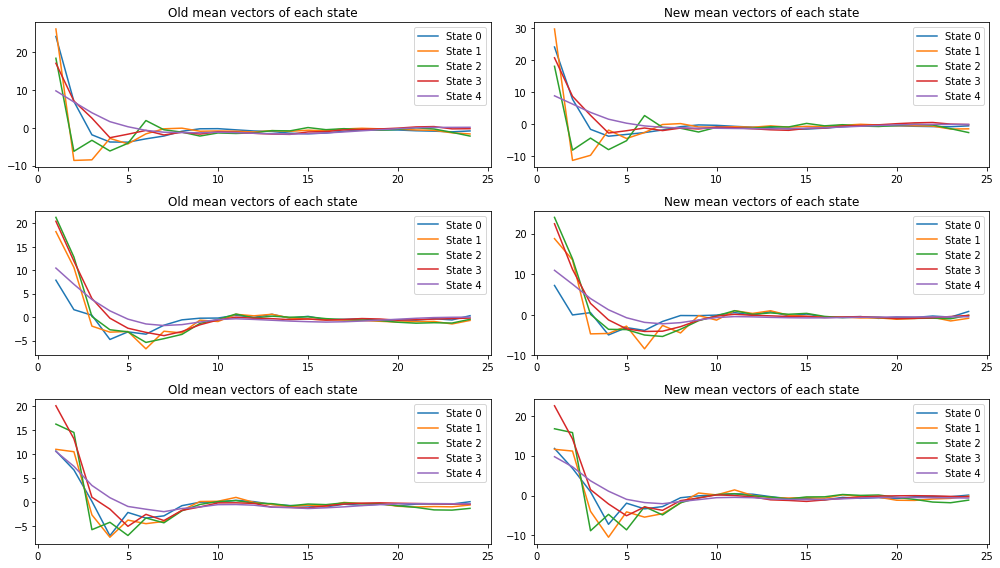

In [42]:
fig, axs = plt.subplots(3,2,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    meanplots = axs[row,0].plot(np.arange(1,25),Lambda[y][1][:,1:].T)
    axs[row,0].set_title('Old mean vectors of each state')
    axs[row,0].legend(meanplots,['State 0','State 1','State 2','State 3','State 4'])
    meanplots = axs[row,1].plot(np.arange(1,25),Lambda_new[y][1][:,1:].T)
    axs[row,1].set_title('New mean vectors of each state')
    axs[row,1].legend(meanplots,['State 0','State 1','State 2','State 3','State 4'])
fig.tight_layout()

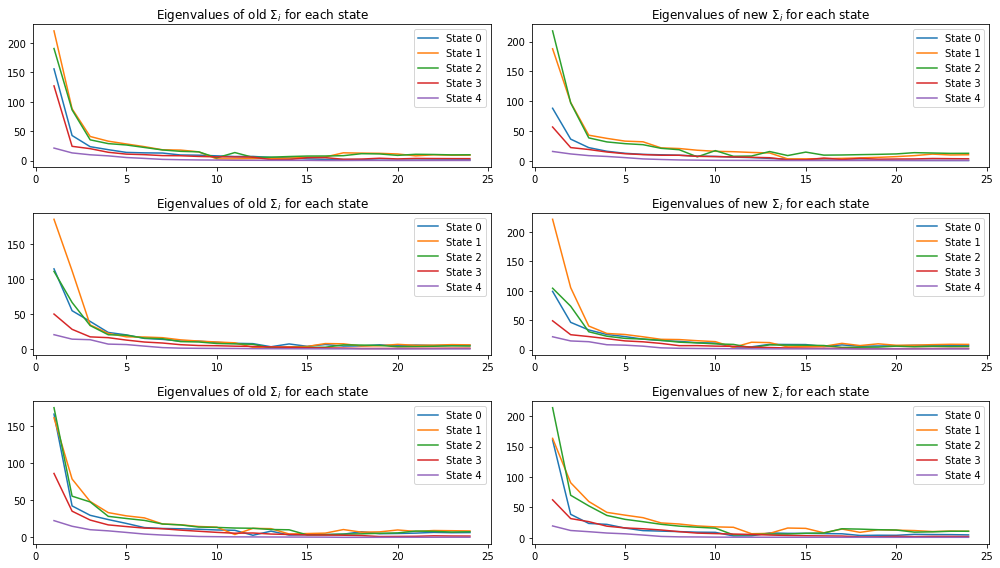

In [43]:
fig, axs = plt.subplots(3,2,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    for i in range(nstates):
        state_eigs, _ = np.linalg.eig(Lambda[y][2][i,:,:])
        axs[row,0].plot(np.arange(1,len(state_eigs)),state_eigs[1:],label='State %d'%(i))
    axs[row,0].set_title('Eigenvalues of old $\Sigma_i$ for each state')
    axs[row,0].legend()
    for i in range(nstates):
        state_eigs, _ = np.linalg.eig(Lambda_new[y][2][i,:,:])
        axs[row,1].plot(np.arange(1,len(state_eigs)),state_eigs[1:],label='State %d'%(i))
    axs[row,1].set_title('Eigenvalues of new $\Sigma_i$ for each state')
    axs[row,1].legend()
fig.tight_layout()

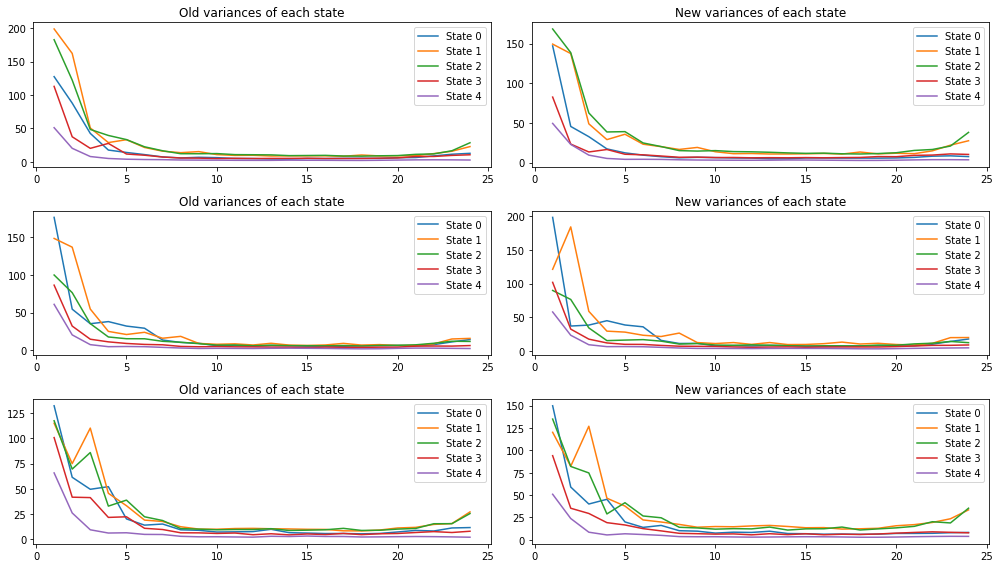

In [44]:
fig, axs = plt.subplots(3,2,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    for i in range(nstates):
        state_std = np.diag(Lambda[y][2][i,1:,1:])
        axs[row,0].plot(np.arange(1,len(global_std)),state_std,label='State %d'%(i))
    axs[row,0].set_title('Old variances of each state')
    axs[row,0].legend()
    for i in range(nstates):
        state_std = np.diag(Lambda_new[y][2][i,1:,1:])
        axs[row,1].plot(np.arange(1,len(global_std)),state_std,label='State %d'%(i))
    axs[row,1].set_title('New variances of each state')
    axs[row,1].legend()
fig.tight_layout()

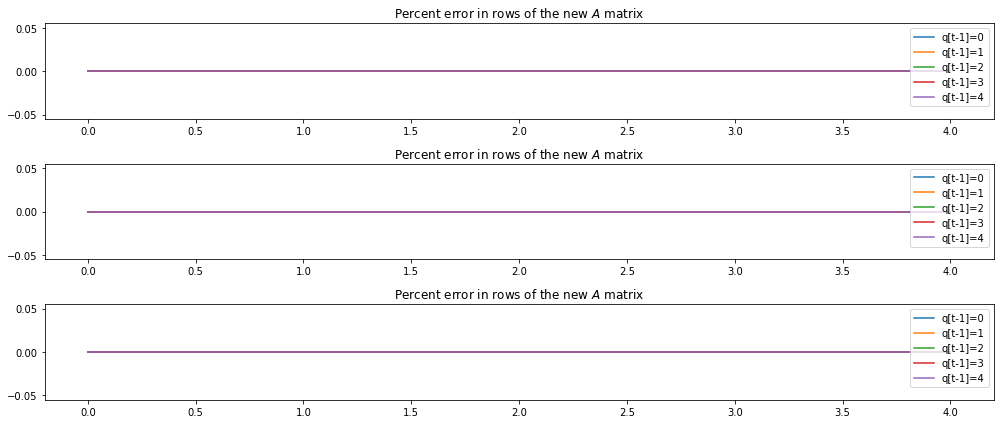

In [45]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        A = Lambda_new[y][0]
        for i in range(nstates):
            err = (A[i,:]-h5['Lambda_new'][y]['0'][i,:])/np.average(np.abs(h5['Lambda_new'][y]['0'][i,:]))
            axs[k].plot(100*err,label='q[t-1]=%d'%(i))
        axs[k].set_title('Percent error in rows of the new $A$ matrix')
        axs[k].legend()
    fig.tight_layout()

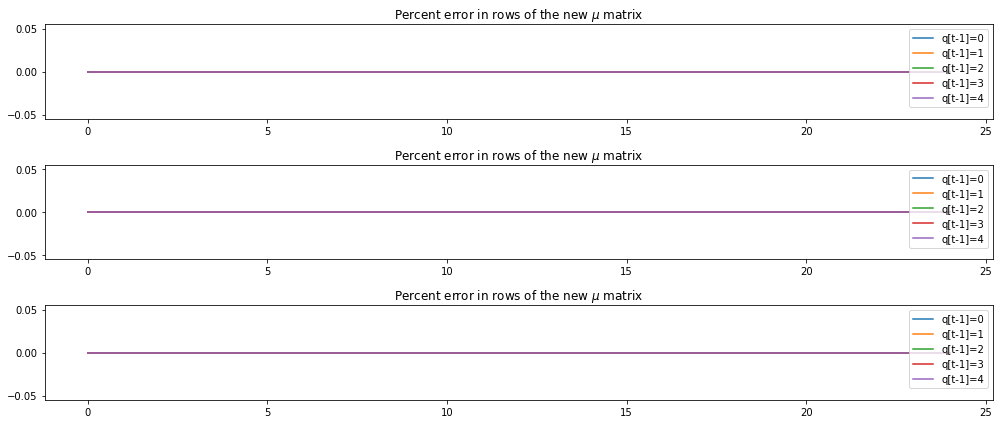

In [46]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        Mu = Lambda_new[y][1]
        for i in range(nstates):
            err = (Mu[i,:]-h5['Lambda_new'][y]['1'][i,:])/np.average(np.abs(h5['Lambda_new'][y]['1'][i,:]))
            axs[k].plot(100*err,label='q[t-1]=%d'%(i))
        axs[k].set_title('Percent error in rows of the new $\mu$ matrix')
        axs[k].legend()
    fig.tight_layout()

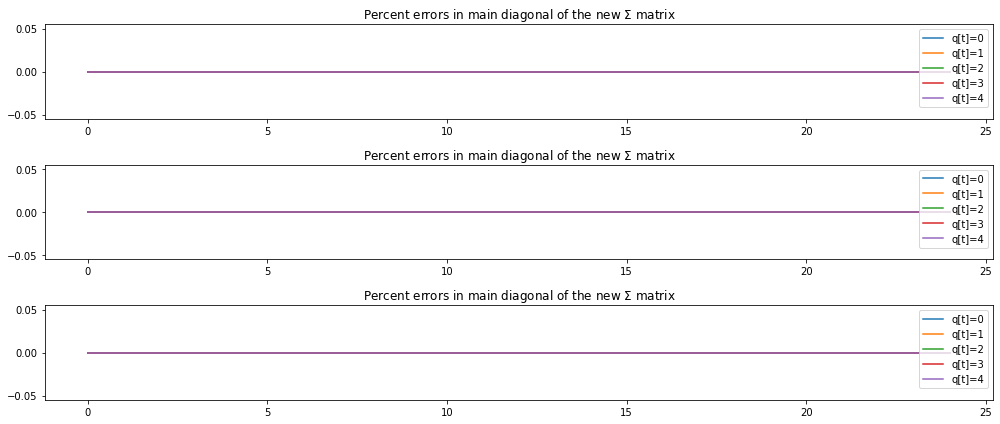

In [47]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        Sigma = Lambda_new[y][2]
        ref = h5['Lambda_new'][y]['2'][:]
        for i in range(nstates):
            err = np.diag(Sigma[i,:,:]-ref[i,:,:])/np.average(np.abs(np.diag(ref[i,:,:])))
            axs[k].plot(100*err,label='q[t]=%d'%(i))
        axs[k].set_title('Percent errors in main diagonal of the new $\Sigma$ matrix')
        axs[k].legend()
    fig.tight_layout()

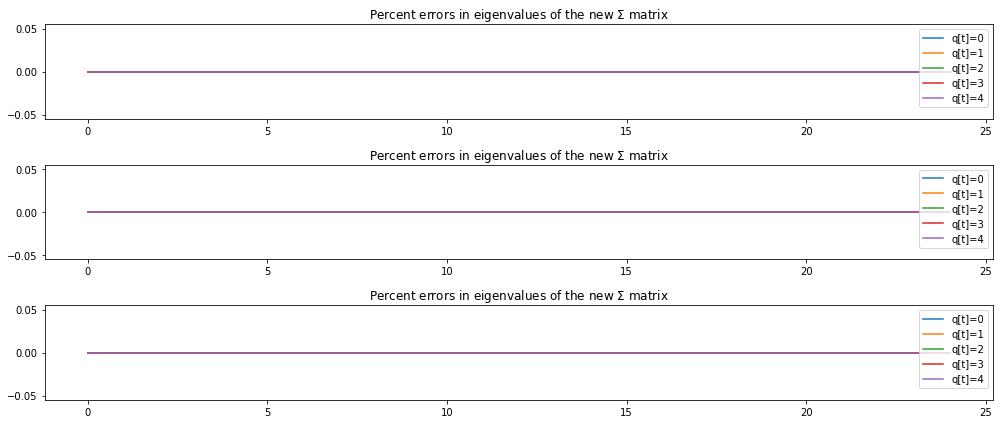

In [48]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        for i in range(nstates):
            eigs_mine, _ = np.linalg.eig(Lambda_new[y][2][i,:,:])
            eigs_solution, _ = np.linalg.eig(h5['Lambda_new'][y]['2'][i,:,:])
            err = (eigs_mine-eigs_solution)/np.average(np.abs(eigs_solution))
            axs[k].plot(100*err,label='q[t]=%d'%(i))
        axs[k].set_title('Percent errors in eigenvalues of the new $\Sigma$ matrix')
        axs[k].legend()
    fig.tight_layout()

-----------------------------------------------------
## Part 8: Recognize Speech!!

In order to recognize speech, we want to calculate the log probability of each of our three models, and then choose the model that has the best log probability.  If $X_n$ is the feature matrix for the $n^{\textrm{th}}$ devtest utterance, and $\Lambda_y$ is the model of word $y$, then:

$$\hat{y}_n = \arg\max_y p(X_n | \Lambda_y)$$


In [49]:
importlib.reload(submitted)
help(submitted.recognize)

Help on function recognize in module submitted:

recognize(X, Models)
    Perform isolated-word speech recognition using trained Gaussian HMMs.
    
    Inputs:
    X (list of (nframes[n],nceps) arrays):
        X[n][t,:] = feature vector, t'th frame of n'th waveform
    Models (dict of tuples):
        Models[y] = (A, Mu, Sigma) for class y
        A (nstates,nstates):
             A[i,j] = p(state[t]=j | state[t-1]=i, Y=y).
        Mu (nstates,nceps):
             Mu[i,:] = mean vector of the i'th state for class y
        Sigma (nstates,nceps,nceps):
             Sigma[i,:,:] = covariance matrix, i'th state for class y
    
    Returns:
    logprob (dict of numpy arrays):
       logprob[y][n] = log p(X[n] | Models[y] )
    Y_hat (list of strings):
       Y_hat[n] = argmax_y p(X[n] | Models[y] )
    
    Implementation Hint: 
    For each y, for each n,
    call observation_pdf, then scaled_forward, then np.log, then np.sum.



We can easily measure accuracy by keeping the results separated, depending on the reference label ('1', '2', or '3') of each devtest sample:

In [50]:
importlib.reload(submitted)
logprob_dict = {}
Yhat_dict = {}
for y in ['1','2','3']:
    logprob_dict[y], Yhat_dict[y] =submitted.recognize(dev_cepstra[y], Lambda_new)
    print('For true label %s, the recognized labels are: '%(y), Yhat_dict[y])

For true label 1, the recognized labels are:  ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
For true label 2, the recognized labels are:  ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3']
For true label 3, the recognized labels are:  ['3', '3', '3', '3', '3', '3', '3', '3', '1', '3', '3', '3', '3', '3', '3', '1', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '1', '1', '1']


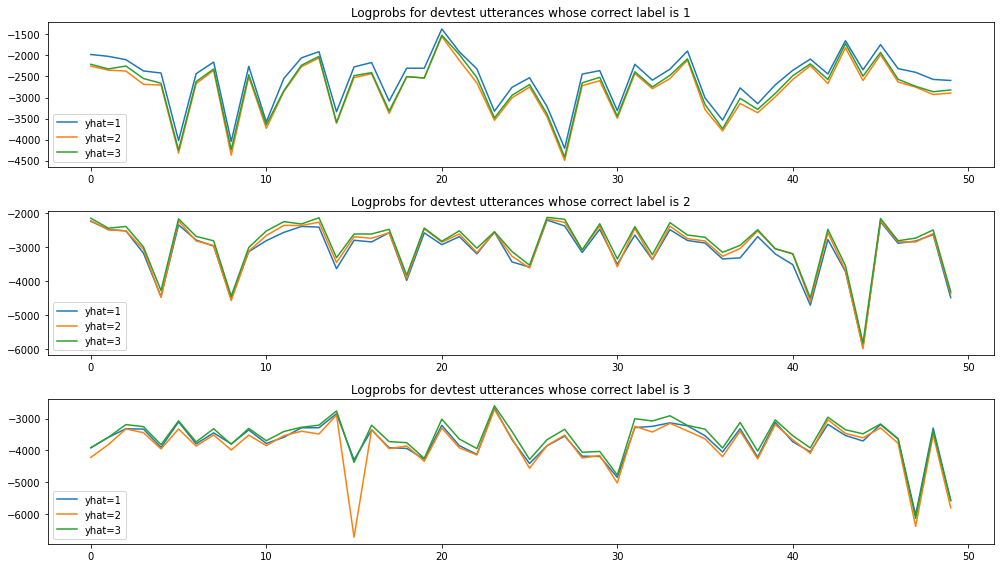

In [51]:
fig, axs = plt.subplots(3,1,figsize=(14,8))
Y=['1','2','3']
for row in range(3):
    y = Y[row]
    for yhat in Y:
        axs[row].plot(logprob_dict[y][yhat],label='yhat=%s'%(yhat))
    axs[row].set_title('Logprobs for devtest utterances whose correct label is %s'%(y))
    axs[row].legend()
fig.tight_layout()

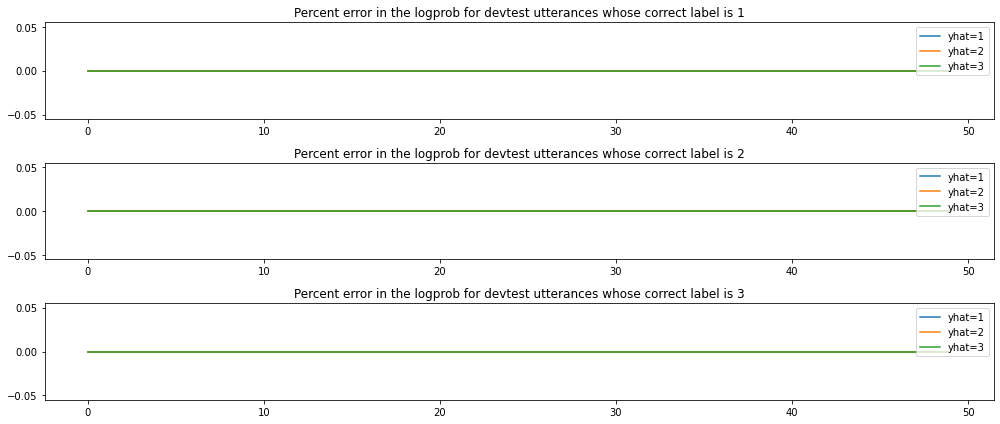

In [52]:
import h5py
with h5py.File('solutions.hdf5','r')  as h5:
    fig, axs = plt.subplots(3,1,figsize=(14,6))
    for k,y in enumerate(train_cepstra.keys()):
        for yhat in Y:
            ref = h5['logprob_dict'][y][yhat]
            err = (logprob_dict[y][yhat]-ref)/np.average(np.abs(ref))
            axs[k].plot(100*err,label='yhat=%s'%(yhat))
        axs[k].set_title('Percent error in the logprob for devtest utterances whose correct label is %s'%(y))
        axs[k].legend()
    fig.tight_layout()

---------------------
## Extra Credit

You can earn up to 10%  extra credit on this MP by finishing the file called `extra.py`, and submitting it to the autograder.

When you unpack the file ``mp2_extra.zip``, it will give you the following files:

* ``extra.py``.  
*  ``tests/test_extra.py``.  

The extra credit assignment this time is to get the best speech recognition accuracy that you can!

In [53]:
import extra
importlib.reload(extra)
help(extra.recognize)

Help on function recognize in module extra:

recognize(Xtrain, Xdev, Xtest)
    Use any technique you like to train a recognizer with the training set,
    and then return the correct class labels for the test set.
    Extra credit points are provided for beating various thresholds above 33% accuracy.
    
    Inputs:
    Xtrain (dict of lists of (nframes,nceps) arrays):
        Xtrain[y][n][t,:] = t'th frame of n'th training utterance of word Y=y
    Xdev (dict of lists of (nframes,nceps) arrays):
        Xdev[y][n][t,:] = t'th frame of n'th devtest utterance of word Y=y
    Xtest (list of (nframes,nceps)  arrays):
        Xtest[n][t,:] = t'th frame of the n'th test utterance
    
    Returns:
    Y_hat (list of scalar strings): 
        Predicted label of each of the test utterances
    
    Implementation Warning:
    For the hidden dataset, the word labels will not be ['1','2','3'].
    Instead of hardcoding ['1','2','3'], use Xtrain.keys() or Xdev.keys().



You can test your accuracy like this:

In [54]:
importlib.reload(extra)
Xtest = test_cepstra['1']+test_cepstra['2']+test_cepstra['3']
Y_ref = ['1']*len(test_cepstra['1']) + ['2']*len(test_cepstra['2']) + ['3']*len(test_cepstra['3'])
Y_hyp = extra.recognize(train_cepstra, dev_cepstra, Xtest)
print('\nY_ref is',Y_ref)
print('\nY_hyp is',Y_hyp)
accuracy = np.count_nonzero([y==yhat for (y,yhat) in zip(Y_ref,Y_hyp)])/len(Y_ref)
print('\naccuracy is',accuracy)


Y_ref is ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3']

Y_hyp is ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'